Dataset already exists.


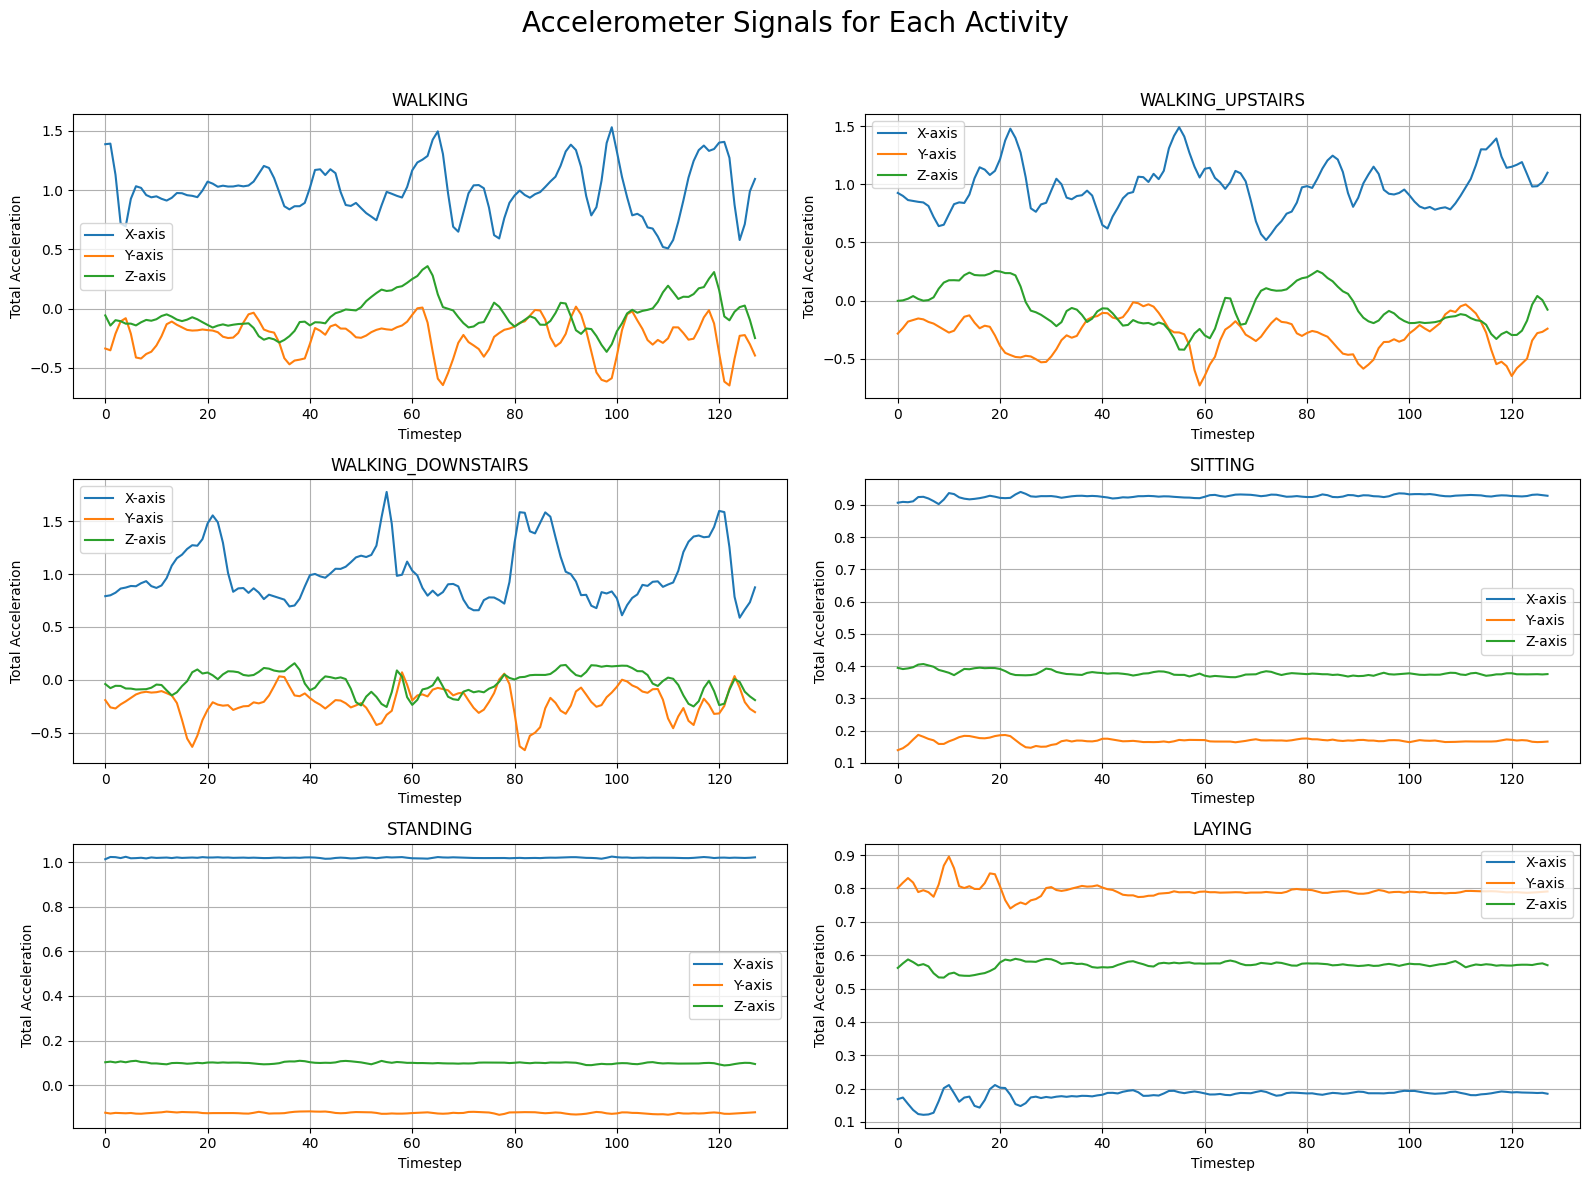


--- Starting Deeper Data Analysis ---


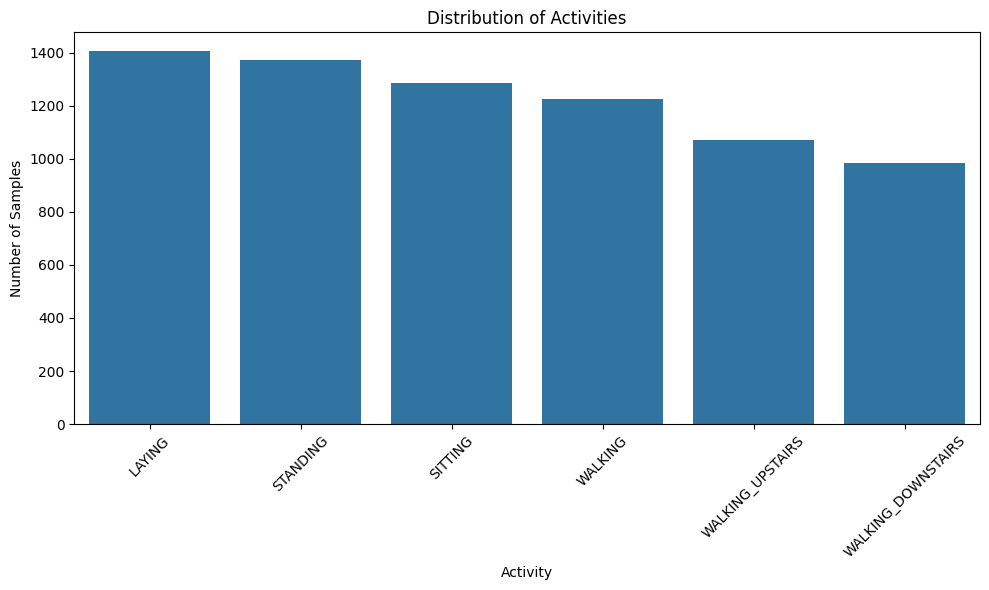

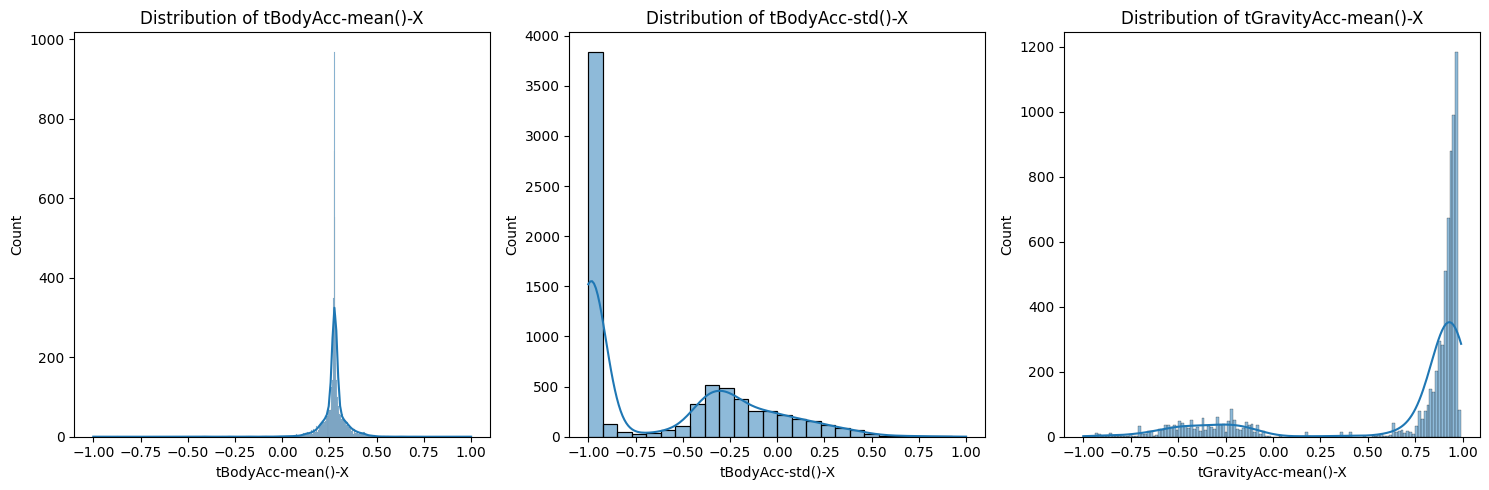

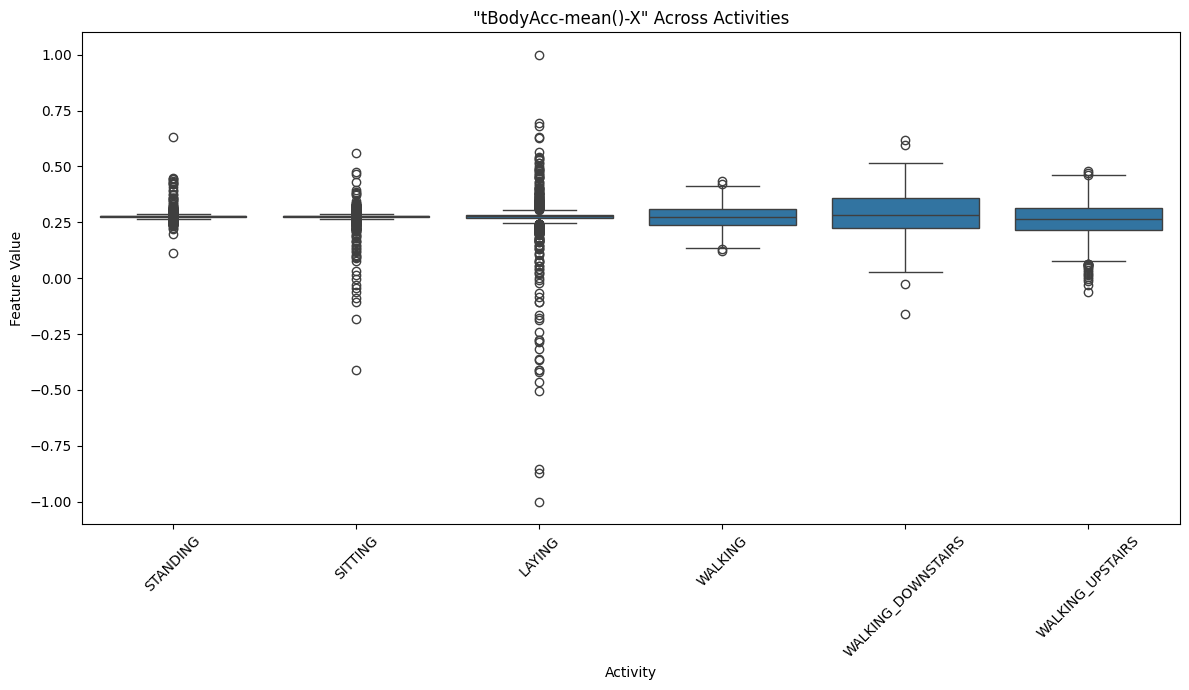

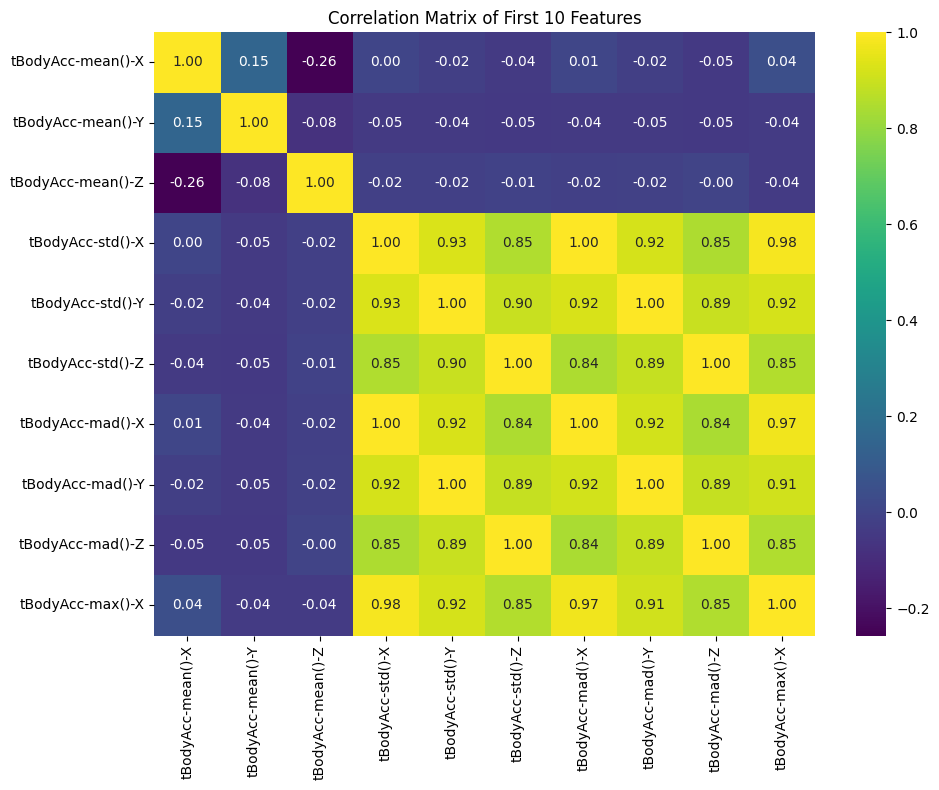


--- Analysis Complete ---


In [2]:
import os
import requests
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Function to Download and Unzip the Dataset ---
def download_and_unzip_data():
    """Downloads and unzips the UCI HAR Dataset if not already present."""
    zip_filename = 'UCI HAR Dataset.zip'
    dataset_folder = 'UCI HAR Dataset'
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'

    if not os.path.exists(dataset_folder):
        print("Downloading dataset...")
        response = requests.get(url, stream=True)
        with open(zip_filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        
        print("Unzipping dataset...")
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall('.')
        
        os.remove(zip_filename)
        print("Dataset ready.")
    else:
        print("Dataset already exists.")

# --- 2. Functions to Load Data ---

# NEW: Helper function to handle duplicate column names
def make_unique_column_names(columns):
    """Makes a list of column names unique by appending suffixes."""
    seen = {}
    new_columns = []
    for col in columns:
        if col in seen:
            seen[col] += 1
            new_columns.append(f"{col}_{seen[col]}")
        else:
            seen[col] = 0
            new_columns.append(col)
    return new_columns

def load_raw_data(split='train'):
    """Loads the raw inertial signals and the corresponding labels."""
    dataset_path = 'UCI HAR Dataset'
    
    labels_path = os.path.join(dataset_path, split, f'y_{split}.txt')
    labels = pd.read_csv(labels_path, header=None).values.flatten()
    
    accel_x_path = os.path.join(dataset_path, split, 'Inertial Signals', f'total_acc_x_{split}.txt')
    accel_y_path = os.path.join(dataset_path, split, 'Inertial Signals', f'total_acc_y_{split}.txt')
    accel_z_path = os.path.join(dataset_path, split, 'Inertial Signals', f'total_acc_z_{split}.txt')
    
    accel_x = pd.read_csv(accel_x_path, delim_whitespace=True, header=None).values
    accel_y = pd.read_csv(accel_y_path, delim_whitespace=True, header=None).values
    accel_z = pd.read_csv(accel_z_path, delim_whitespace=True, header=None).values
    
    raw_data = np.stack([accel_x, accel_y, accel_z], axis=-1)
    
    return raw_data, labels

# MODIFIED: This function now uses the helper function to fix names
def load_feature_data(split='train'):
    """Loads the pre-processed feature data and labels with unique column names."""
    dataset_path = 'UCI HAR Dataset'
    
    # Load original feature names
    features_path = os.path.join(dataset_path, 'features.txt')
    feature_names = pd.read_csv(features_path, delim_whitespace=True, header=None, index_col=0).iloc[:, 0].tolist()
    
    # Make feature names unique
    unique_feature_names = make_unique_column_names(feature_names)
    
    # Load data with unique names
    data_path = os.path.join(dataset_path, split, f'X_{split}.txt')
    data = pd.read_csv(data_path, delim_whitespace=True, header=None, names=unique_feature_names)
    
    labels_path = os.path.join(dataset_path, split, f'y_{split}.txt')
    labels = pd.read_csv(labels_path, header=None, names=['Activity'])
    
    return data, labels

# --- Main Visualization Code ---

# Download data if needed
download_and_unzip_data()

# Load the training data (raw)
X_train_raw, y_train_orig = load_raw_data('train')

# Define the labels for plotting
activity_labels = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

# Create a plot with 6 subplots for raw signals
fig, axs = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Accelerometer Signals for Each Activity', fontsize=20)
axs = axs.flatten()

for label_num, activity_name in activity_labels.items():
    try:
        first_occurrence_idx = np.where(y_train_orig == label_num)[0][0]
    except IndexError:
        print(f"Warning: No samples found for activity '{activity_name}' in the dataset.")
        continue

    sample_data = X_train_raw[first_occurrence_idx]
    df = pd.DataFrame(sample_data, columns=['x', 'y', 'z'])
    df['timestep'] = df.index
    
    ax = axs[label_num - 1]
    ax.plot(df['timestep'], df['x'], label='X-axis')
    ax.plot(df['timestep'], df['y'], label='Y-axis')
    ax.plot(df['timestep'], df['z'], label='Z-axis')
    
    ax.set_title(activity_name)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Total Acceleration')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- 3. Deeper Data Analysis ---

print("\n--- Starting Deeper Data Analysis ---")

# Load feature data
X_train_feat, y_train_feat = load_feature_data('train')
y_train_feat['ActivityName'] = y_train_feat['Activity'].map(activity_labels)

# --- 3.1. Activity Distribution ---
plt.figure(figsize=(10, 6))
sns.countplot(x='ActivityName', data=y_train_feat, order=y_train_feat['ActivityName'].value_counts().index)
plt.title('Distribution of Activities')
plt.xticks(rotation=45)
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

# --- 3.2. Feature Distributions (for selected features) ---
selected_features = ['tBodyAcc-mean()-X', 'tBodyAcc-std()-X', 'tGravityAcc-mean()-X']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(X_train_feat[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# --- 3.3. Feature Distribution Across Activities (Boxplots) ---
feature_to_plot = 'tBodyAcc-mean()-X'
plt.figure(figsize=(12, 7))
sns.boxplot(x='ActivityName', y=feature_to_plot, data=pd.concat([X_train_feat, y_train_feat], axis=1))
plt.title(f'"{feature_to_plot}" Across Activities')
plt.xticks(rotation=45)
plt.xlabel('Activity')
plt.ylabel('Feature Value')
plt.tight_layout()
plt.show()

# --- 3.4. Correlation Matrix of the First 10 Features ---
plt.figure(figsize=(10, 8))
correlation_matrix = X_train_feat.iloc[:, :10].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Matrix of First 10 Features')
plt.tight_layout()
plt.show()

print("\n--- Analysis Complete ---")

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set a visually appealing plot style
sns.set(style="whitegrid", font_scale=1.2)

# --- Configuration ---
# Ensure your data folder is named 'my_recordings' and is in the same directory as your notebook
DATA_DIR = 'my_recordings'

def load_all_recordings(directory):
    """Loads all CSV files from a directory into a single DataFrame."""
    all_files = []
    print(f"Searching for files in: {os.path.abspath(directory)}")
    
    # Check if directory exists
    if not os.path.isdir(directory):
        print(f"Error: Directory '{directory}' not found.")
        print("Please make sure your recordings are in a folder named 'my_recordings'.")
        return pd.DataFrame()

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            try:
                df = pd.read_csv(filepath)
                # Ensure all necessary columns exist
                if all(col in df.columns for col in ['timestamp', 'label', 'session_id']):
                    all_files.append(df)
                else:
                    print(f"Warning: Skipping file '{filename}' due to missing required columns.")
            except Exception as e:
                print(f"Warning: Could not read file '{filename}'. Error: {e}")

    if not all_files:
        print("Error: No valid CSV files were loaded.")
        return pd.DataFrame()
        
    return pd.concat(all_files, ignore_index=True)

# Load the data
raw_df = load_all_recordings(DATA_DIR)

if not raw_df.empty:
    print(f"\nSuccessfully loaded a total of {raw_df.shape[0]} data points.")
    print(f"Found {raw_df['session_id'].nunique()} unique recording sessions.")
    print("\nFirst 5 rows of the raw data:")
    print(raw_df.head())

Searching for files in: /home/amine/MET-Tracker-App/my_recordings

Successfully loaded a total of 37931 data points.
Found 12 unique recording sessions.

First 5 rows of the raw data:
       timestamp         x         y         z     label  \
0  1756553434538 -0.353516  0.114746  1.117188  Vigorous   
1  1756553434589 -0.356934  0.209473  0.505371  Vigorous   
2  1756553434643 -0.346191  0.027100  1.187744  Vigorous   
3  1756553434699 -0.201904  0.095703  0.628174  Vigorous   
4  1756553434754 -0.357422 -0.034424  1.497559  Vigorous   

               session_id  
0  1756553629116_Vigorous  
1  1756553629116_Vigorous  
2  1756553629116_Vigorous  
3  1756553629116_Vigorous  
4  1756553629116_Vigorous  


In [4]:
def trim_sessions(df, trim_ms=3000):
    """Removes the first and last `trim_ms` milliseconds from each session."""
    if df.empty or 'session_id' not in df.columns:
        return pd.DataFrame()
        
    trimmed_dfs = []
    # Group data by each individual recording session
    for session_id, group in df.groupby('session_id'):
        start_time = group['timestamp'].min()
        end_time = group['timestamp'].max()
        
        # Create a boolean mask for the time window we want to keep
        time_mask = (group['timestamp'] > start_time + trim_ms) & (group['timestamp'] < end_time - trim_ms)
        trimmed_dfs.append(group[time_mask])
        
    return pd.concat(trimmed_dfs, ignore_index=True)

if not raw_df.empty:
    trimmed_df = trim_sessions(raw_df)

    print(f"Original data points: {raw_df.shape[0]}")
    print(f"Data points after trimming: {trimmed_df.shape[0]}")
    print(f"Removed a total of {raw_df.shape[0] - trimmed_df.shape[0]} data points.")

Original data points: 37931
Data points after trimming: 36592
Removed a total of 1339 data points.


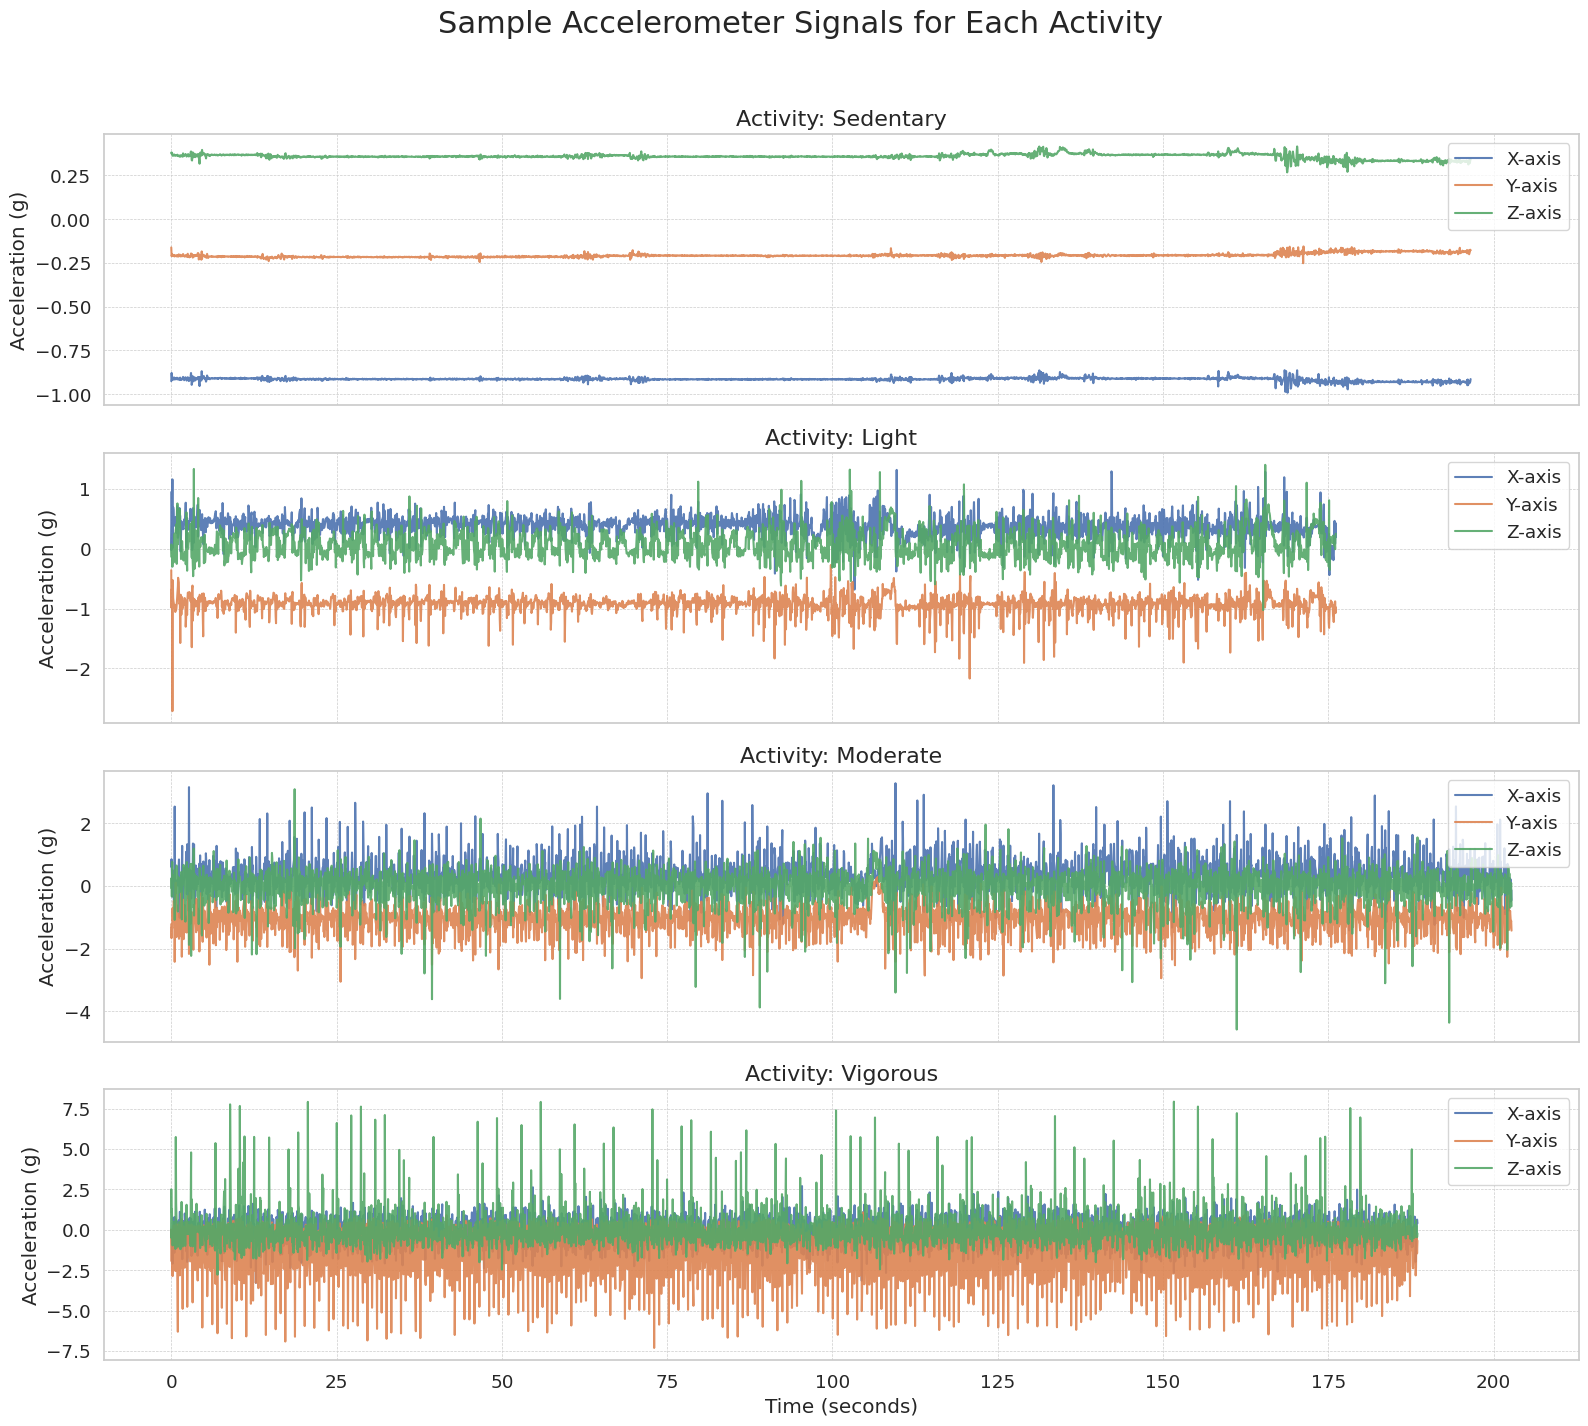

In [5]:
if not trimmed_df.empty:
    labels = trimmed_df['label'].unique()
    # Define a consistent order for plotting
    plot_order = [label for label in ['Sedentary', 'Light', 'Moderate', 'Vigorous'] if label in labels]

    fig, axes = plt.subplots(len(plot_order), 1, figsize=(16, 14), sharex=True)
    fig.suptitle('Sample Accelerometer Signals for Each Activity', fontsize=22, y=1.02)

    for i, label in enumerate(plot_order):
        # Find the first session for the current label to use as a sample
        sample_session_id = trimmed_df[trimmed_df['label'] == label]['session_id'].iloc[0]
        sample_df = trimmed_df[trimmed_df['session_id'] == sample_session_id].copy()
        
        # Create a relative time axis (in seconds) for a clean plot
        sample_df['time_sec'] = (sample_df['timestamp'] - sample_df['timestamp'].min()) / 1000
        
        ax = axes[i]
        ax.plot(sample_df['time_sec'], sample_df['x'], label='X-axis', alpha=0.9)
        ax.plot(sample_df['time_sec'], sample_df['y'], label='Y-axis', alpha=0.9)
        ax.plot(sample_df['time_sec'], sample_df['z'], label='Z-axis', alpha=0.9)
        
        ax.set_title(f'Activity: {label}', fontsize=16)
        ax.set_ylabel('Acceleration (g)')
        ax.legend(loc='upper right')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    axes[-1].set_xlabel('Time (seconds)')
    plt.tight_layout()
    plt.show()

In [6]:
if not trimmed_df.empty:
    trimmed_df['magnitude'] = np.sqrt(trimmed_df['x']**2 + trimmed_df['y']**2 + trimmed_df['z']**2)
    print("Calculated vector magnitude. Here are the summary statistics per class:")
    
    # Use describe() to see the statistical summary for our new feature, grouped by activity
    print(trimmed_df[['magnitude', 'label']].groupby('label').describe())

Calculated vector magnitude. Here are the summary statistics per class:
          magnitude                                                    \
              count      mean       std       min       25%       50%   
label                                                                   
Light       10015.0  1.019942  0.110817  0.390390  0.993771  1.006441   
Moderate    10453.0  1.277160  0.749536  0.078897  0.853439  1.107180   
Sedentary   10407.0  1.001213  0.011633  0.617444  0.997229  1.002383   
Vigorous     5717.0  1.758212  1.457460  0.014280  0.744485  1.325132   

                               
                75%       max  
label                          
Light      1.024492  3.428472  
Moderate   1.523983  8.766192  
Sedentary  1.005516  1.204867  
Vigorous   2.291406  8.583191  


/tmp/ipykernel_2050302/1194497821.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


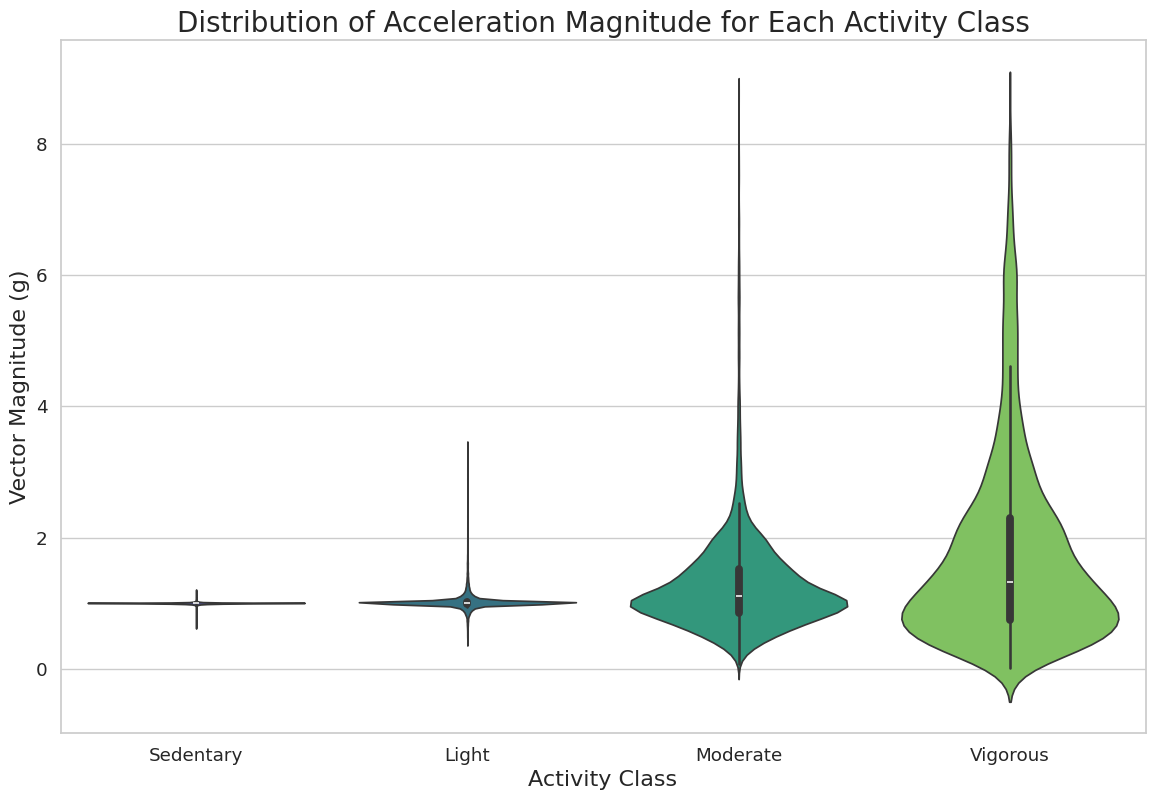

In [7]:
if not trimmed_df.empty:
    plt.figure(figsize=(14, 9))

    # Use a violin plot to visualize the distribution of the 'magnitude' feature
    sns.violinplot(
        x='label', 
        y='magnitude', 
        data=trimmed_df, 
        order=['Sedentary', 'Light', 'Moderate', 'Vigorous'],
        palette='viridis'
    )

    plt.title('Distribution of Acceleration Magnitude for Each Activity Class', fontsize=20)
    plt.xlabel('Activity Class', fontsize=16)
    plt.ylabel('Vector Magnitude (g)', fontsize=16)
    plt.show()

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set a visually appealing plot style
sns.set(style="whitegrid", font_scale=1.2)

# --- Configuration ---
DATA_DIR = 'my_recordings'
WINDOW_SIZE = 51  # 51 samples (~2.56s at 20Hz)
OVERLAP_PERCENTAGE = 0.2  # 50% overlap between windows
STEP_SIZE = int(WINDOW_SIZE * (1 - OVERLAP_PERCENTAGE))

def load_all_recordings(directory):
    """Loads all CSV files from a directory into a single DataFrame."""
    all_files = []
    if not os.path.isdir(directory):
        print(f"Error: Directory '{directory}' not found.")
        return pd.DataFrame()

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            all_files.append(df)

    if not all_files:
        print("Error: No CSV files were loaded.")
        return pd.DataFrame()
        
    return pd.concat(all_files, ignore_index=True)

# Load the data
raw_df = load_all_recordings(DATA_DIR)

if not raw_df.empty:
    print(f"Successfully loaded {raw_df.shape[0]} data points from {raw_df['session_id'].nunique()} sessions.")
    print(raw_df.head())

Successfully loaded 37931 data points from 12 sessions.
       timestamp         x         y         z     label  \
0  1756553434538 -0.353516  0.114746  1.117188  Vigorous   
1  1756553434589 -0.356934  0.209473  0.505371  Vigorous   
2  1756553434643 -0.346191  0.027100  1.187744  Vigorous   
3  1756553434699 -0.201904  0.095703  0.628174  Vigorous   
4  1756553434754 -0.357422 -0.034424  1.497559  Vigorous   

               session_id  
0  1756553629116_Vigorous  
1  1756553629116_Vigorous  
2  1756553629116_Vigorous  
3  1756553629116_Vigorous  
4  1756553629116_Vigorous  


In [12]:
def process_data_uci_style(df):
    """Applies the full UCI-inspired processing pipeline to the raw data."""
    if df.empty:
        return pd.DataFrame()
    
    feature_data = []

    # 1. Trim the start and end of each session
    def trim_sessions(df, trim_ms=3000):
        trimmed_dfs = []
        for session_id, group in df.groupby('session_id'):
            start_time = group['timestamp'].min()
            end_time = group['timestamp'].max()
            time_mask = (group['timestamp'] > start_time + trim_ms) & (group['timestamp'] < end_time - trim_ms)
            trimmed_dfs.append(group[time_mask])
        return pd.concat(trimmed_dfs, ignore_index=True)

    processed_df = trim_sessions(df)
    
    # Process each session individually to prevent windows from crossing over recordings
    for session_id, session_df in processed_df.groupby('session_id'):
        
        # 2. Smooth the signals with a moving average
        # Using a small window of 5 samples for smoothing
        session_df[['x', 'y', 'z']] = session_df[['x', 'y', 'z']].rolling(window=5, min_periods=1, center=True).mean()

        # 3. Create overlapping windows
        for i in range(0, len(session_df) - WINDOW_SIZE + 1, STEP_SIZE):
            window = session_df.iloc[i:i + WINDOW_SIZE]
            
            # 4. Extract features for each window
            features = {}
            label = window['label'].iloc[0] # All labels in a window are the same

            for axis in ['x', 'y', 'z']:
                signal = window[axis]
                features[f'mean_{axis}'] = signal.mean()
                features[f'std_{axis}'] = signal.std()
                features[f'min_{axis}'] = signal.min()
                features[f'max_{axis}'] = signal.max()
            
            features['label'] = label
            feature_data.append(features)

    return pd.DataFrame(feature_data)

# Run the pipeline
features_df = process_data_uci_style(raw_df)

if not features_df.empty:
    print("Data processing complete.")
    print(f"Created a new feature dataset with {features_df.shape[0]} windows (rows) and {features_df.shape[1]-1} features.")
    print("\nFirst 5 rows of the new feature dataset:")
    print(features_df.head())

Data processing complete.
Created a new feature dataset with 905 windows (rows) and 12 features.

First 5 rows of the new feature dataset:
     mean_x     std_x     min_x     max_x    mean_y     std_y     min_y  \
0 -0.911349  0.002707 -0.915918 -0.903259 -0.208058  0.003976 -0.213672   
1 -0.911910  0.005335 -0.923779 -0.899170 -0.208611  0.003252 -0.216211   
2 -0.909752  0.004287 -0.923340 -0.899170 -0.212924  0.002382 -0.216211   
3 -0.909969  0.000791 -0.911230 -0.907764 -0.213820  0.000729 -0.215625   
4 -0.910273  0.000653 -0.911475 -0.909033 -0.213970  0.000434 -0.214893   

      max_y    mean_z     std_z     min_z     max_z      label  
0 -0.191732  0.365427  0.003370  0.360303  0.378092  Sedentary  
1 -0.201123  0.365477  0.007319  0.347217  0.380566  Sedentary  
2 -0.204980  0.368124  0.005574  0.351807  0.380566  Sedentary  
3 -0.212451  0.367442  0.000763  0.365723  0.368896  Sedentary  
4 -0.212891  0.367922  0.000703  0.366260  0.369531  Sedentary  


/tmp/ipykernel_2050302/2621272759.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


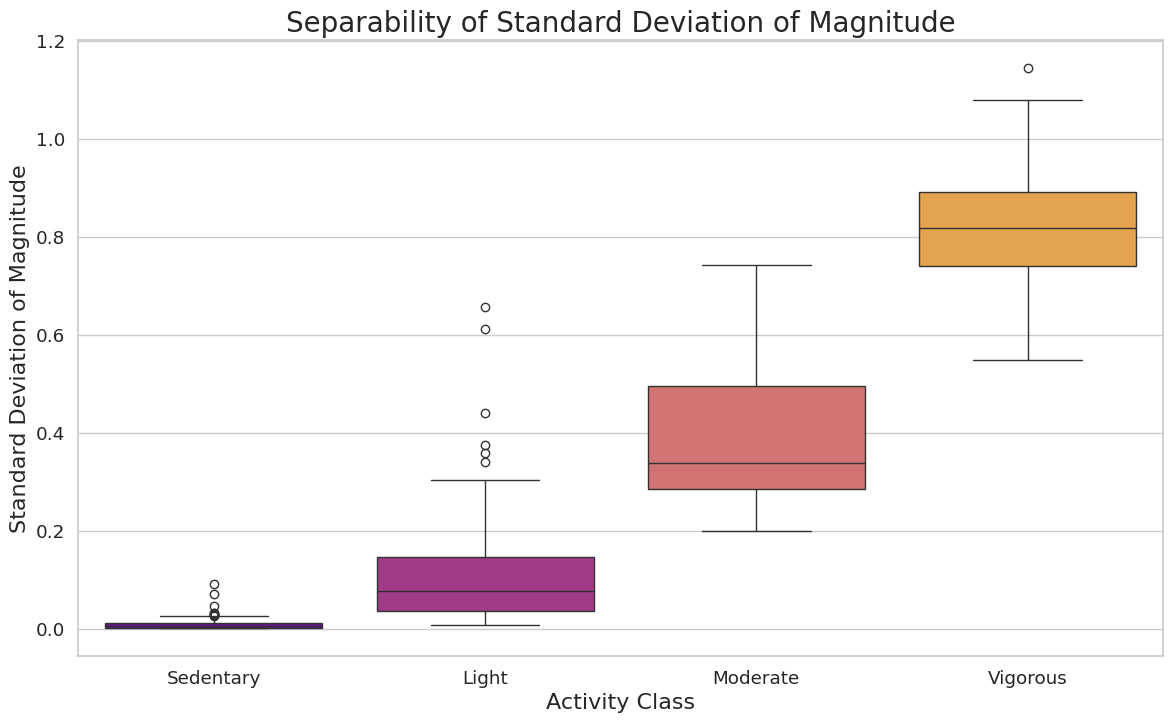

\n--- Pair Plot of Key Features ---
This plot shows how different features relate to each other.
Well-separated clusters in the scatter plots are a great sign for machine learning.


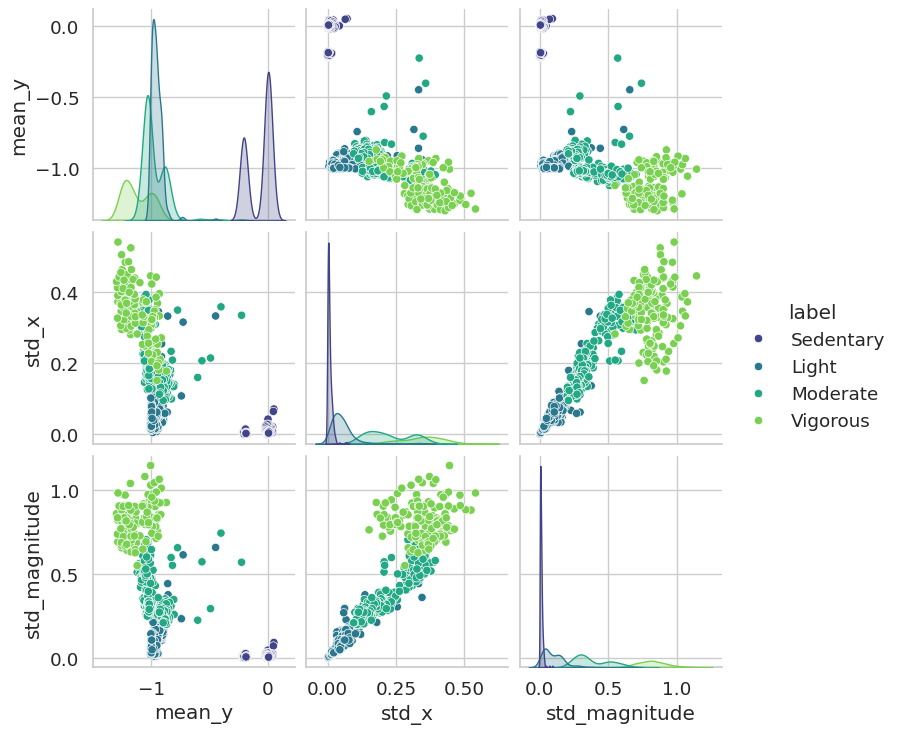

In [13]:
if not features_df.empty:
    # Let's create a magnitude feature from our windowed stats for better visualization
    features_df['std_magnitude'] = np.sqrt(features_df['std_x']**2 + features_df['std_y']**2 + features_df['std_z']**2)
    
    # --- PLOT 1: Box Plot of a Powerful Feature ---
    # Standard deviation of magnitude is often a great separator for activity levels
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        x='label', 
        y='std_magnitude', 
        data=features_df,
        order=['Sedentary', 'Light', 'Moderate', 'Vigorous'],
        palette='plasma'
    )
    plt.title('Separability of Standard Deviation of Magnitude', fontsize=20)
    plt.xlabel('Activity Class', fontsize=16)
    plt.ylabel('Standard Deviation of Magnitude', fontsize=16)
    plt.show()

    # --- PLOT 2: Pair Plot to See Relationships Between Features ---
    print("\\n--- Pair Plot of Key Features ---")
    print("This plot shows how different features relate to each other.")
    print("Well-separated clusters in the scatter plots are a great sign for machine learning.")

    # We select a few key features to keep the plot readable
    pairplot_features = ['mean_y', 'std_x', 'std_magnitude', 'label']
    
    sns.pairplot(
        features_df[pairplot_features],
        hue='label',
        hue_order=['Sedentary', 'Light', 'Moderate', 'Vigorous'],
        palette='viridis',
        diag_kind='kde' # Use Kernel Density Estimate for diagonals
    )
    plt.show()